Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a complete dataset that can be used to train machine learning models.

Mean / median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).

Note the following:

If a variable is normally distributed, the mean, median and mode, are approximately the same. Therefore, replacing missing values by the mean and the median are equivalent. Replacing missing data by the mode is not common practice for numerical variables.
If the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.
For discrete variables casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, we can replace NA with the median instead. The median will inevitably be an integer / discrete value as well.

Note: The mean and median can only be calculated on numerical variables, therefore these methods are suitable for continuous and discrete numerical variables only.

Assumptions:

Data is missing completely at random (MCAR)
The missing observations, most likely look like the majority of the observations in the variable (aka, the mean / median)
If data is missing completely at random, then it is fair to assume that the missing values, are most likely very close to the value of the mean or the median of the distribution, as these represent the most frequent / average observation.

In this demo we will be using Titanic dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [3]:
#look for the % of NA
data.isnull().mean()

survived    0.000000
age         0.198653
fare        0.000000
dtype: float64

so the age column has about 20% missing values

Note: Imputation should be done over the training set, and then propagated to the test set. This means that the mean / median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [5]:
# Let's explore the missing data in the train set, the percentages should be fairly similar to those of the whole dataset

X_train.isnull().mean()

age     0.194222
fare    0.000000
dtype: float64

In [6]:
# let's make a function to fill missing values with the mean or median

def impute_na(df, variable, mean_median):
    return df[variable].fillna(mean_median)


In [7]:
# calculate the median Age

median = X_train.age.median()
median

29.0

In [8]:
# calculate the mean Age

mean = X_train.age.mean()
mean

29.915338645418327

In [9]:
# create a new variable with the missing values replaced using the impute_na function

#first replace with the median
X_train['age_median'] = impute_na(X_train, 'age', median)

In [12]:
# now replace with the mean
X_train['age_mean'] = impute_na(X_train, 'age', mean)

X_train['age_mean'] = np.round(X_train['age_mean'], 1)

X_train.head(15)

,age,fare,age_median,age_mean
857,51.0,26.5500,51.0,51.0
52,49.0,76.7292,49.0,49.0
386,1.0,46.9000,1.0,1.0
124,54.0,77.2875,54.0,54.0
578,NaN,14.4583,29.0,29.9
549,8.0,36.7500,8.0,8.0
118,24.0,247.5208,24.0,24.0
12,20.0,8.0500,20.0,20.0
157,30.0,8.0500,30.0,30.0
127,24.0,7.1417,24.0,24.0


In [13]:
# Look at the rows with missing data (NaN) in Age
print('Original variable variance: ', X_train['age'].var())
print('Variance after median imputation: ', X_train['age_median'].var())
print('Variance after mean imputation: ', X_train['age_mean'].var())

Original variable variance:  210.45286924636747
Variance after median imputation:  169.64401397346137
Variance after mean imputation:  169.51269265508222


As expected, the variance is underestimated, because now many values are the same ==> either the mean or the median value

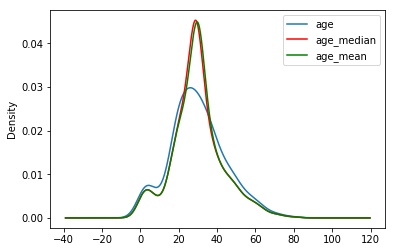

In [14]:
# we can see that the distribution has changed with now more values accumulating towards the mean or median

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['age_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['age_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

The mean / median imputation distorts the original distribution of the variable Age. The transformed variable shows more values around the mean / median values.

Is this important?

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Mean / median imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

In [16]:
# we also said that mean / median imputation may affect the relationship with the other variables in the dataset, 
#let's have a look

X_train[['fare', 'age', 'age_median', 'age_mean']].cov()

,fare,age,age_median,age_mean
fare,2328.801583,78.468894,64.684488,63.223925
age,78.468894,210.452869,210.452869,210.452848
age_median,64.684488,210.452869,169.644014,169.514865
age_mean,63.223925,210.452848,169.514865,169.512693


We see indeed that the covariance between Age and Fare is changed after the mean / median imputation.

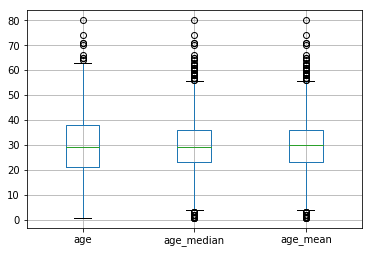

In [18]:
# Finally, I mentioned that mean / median imputation may lead to observations that are normal, to look like outliers
# or in other words, mean / median imputation may lead to an increase in the apparent number of  outliers

# Let's find out using a boxplot
X_train[['age', 'age_median', 'age_mean']].boxplot()

From the boxplot above, we can see that after the imputation not only we have more outliers on the higher Age values, but we have now outliers as well for the lower values of Age.

Is this important?

If we are after true outliers, we need to keep this behaviour in mind, to make sure that we are neither masking nor creating artificial outliers with our imputation technique. In practice, we normally don't check for this behaviour at all. But I think it is important to know that is happening.